# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import source_statistics as ss
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
basefile = 'source_sequential_201707031206.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
#measure = 'mu_mean'
measure = 'mu_p_large'

# which regressors should define the empirical value distribution?
# set regressors = None for all
#regressors = ['response']
regressors = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y']

# do not use these regressors to define empirical value distribution
exclude = 'trialregs'
#exclude = 'dotregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = ss.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    exclude=exclude, verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

excluding:
intercept
entropy
response
trial_time

adding abs_dot_x
adding abs_dot_y
adding dot_x
adding dot_y
N = 101360

threshold = 0.5100


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.04}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = ss.get_fdrcorr_clusters(basefile, regressors, measure, threshold, measure_cdf,
                                   fdr_alpha=0.001)

print('cluster counts:')
print(clusters.label.groupby(level='regressor').count())

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

cluster counts:
regressor
dot_x        234
dot_y         46
abs_dot_x     50
abs_dot_y     21
Name: label, dtype: int64


label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     103         L_5L_ROI-lh       30     80  -9.612352    6.535747e-09   
          979         R_V2_ROI-rh      100    130 -10.386901    1.193414e-09   
          718        R_DVT_ROI-rh      100    130  -6.822627    2.556690e-06   
          421        L_V3A_ROI-lh      110    130  -5.260115    7.055753e-05   
          908       R_ProS_ROI-rh      110    130  -4.809204    1.784704e-04   
          415         L_V2_ROI-lh      110    130  -6.834924    2.544640e-06   
          998         R_V3_ROI-rh      110    130  -6.442309    5.905340e-06   
          518      L_v23ab_ROI-lh      110    130  -7.546101    5.659540e-07   
          424        L_V3B_ROI-lh      110    140  -6.832061    2.544640e-06   
          1084     R_v23ab_ROI-rh      110    120  -5.361814    5.717196e-05   
          431         L_V3_ROI-lh      110    130  -7.534665    5.735086e-07   
          411         L_V1_ROI-lh      110    140  -9.921946    3.415654e-09   
          916         R_RI_ROI-rh      120    130  -4.001448    8.688569e-04   
          1019       R_VIP_ROI-rh      140    180  -8.960248    2.739633e-08   
          1005       R_V6A_ROI-rh      140    190 -11.513333    9.974925e-11   
          767       R_IPS1_ROI-rh      140    190 -12.128380    2.587175e-11   
          519      L_v23ab_ROI-lh      150    190 -11.856874    4.725651e-11   
          659        R_7Am_ROI-rh      150    180 -10.622633    7.285462e-10   
          1014        R_V7_ROI-rh      150    200 -17.719554    1.202072e-16   
          329       L_POS2_ROI-lh      150    200 -13.801979    6.916669e-13   
          719        R_DVT_ROI-rh      150    190 -14.066126    4.059004e-13   
          757        R_IP0_ROI-rh      150    190 -14.344911    2.317192e-13   
          1085     R_v23ab_ROI-rh      150    200 -12.168070    2.416775e-11   
          840        R_PCV_ROI-rh      150    180  -7.221418    1.135500e-06   
          221       L_IPS1_ROI-lh      150    200 -14.804310    8.184417e-14   
          871        R_PGp_ROI-rh      150    190 -10.446584    1.060574e-09   
          46           L_2_ROI-lh      150    180  -9.769373    4.676918e-09   
          127        L_7Am_ROI-lh      150    180  -9.151926    1.791648e-08   
          166        L_DVT_ROI-lh      150    200 -15.298412    2.766624e-14   
          986        R_V3B_ROI-rh      160    180  -6.249052    8.879173e-06   
...                           ...      ...    ...        ...             ...   
abs_dot_x 536        R_FFC_ROI-rh      490    510  -4.388570    3.925050e-04   
          339       L_VMV2_ROI-lh      520    540  -4.468832    3.391958e-04   
          571        R_IP1_ROI-rh      530    550  -5.216035    7.728819e-05   
          850      R_v23ab_ROI-rh      580    600  -4.351296    4.249820e-04   
          521        R_AVI_ROI-rh      590    610  -4.640719    2.458454e-04   
          277        L_RSC_ROI-lh      640    650  -4.067124    7.578366e-04   
          818      R_d23ab_ROI-rh      650    660  -4.439099    3.596710e-04   
          771         R_V2_ROI-rh      650    670  -4.759763    1.955284e-04   
          47          L_3b_ROI-lh      660    690  -5.555243    3.743689e-05   
abs_dot_y 238        L_VIP_ROI-lh       20     40  -5.849665    1.988940e-05   
          139        L_LO1_ROI-lh      150    170  -5.332904    6.065997e-05   
          97         L_DVT_ROI-lh      160    180  -4.400591    3.857024e-04   
          229        L_V6A_ROI-lh      170    190  -4.538901    2.974932e-04   
          508         R_V4_ROI-rh      170    190  -4.434658    3.610078e-04   
          258      L_d23ab_ROI-lh      180    220  -9.826133    4.141576e-09   
          30        L_31pd_ROI-lh      190    210  -5.258223    7.055753e-05   
          9          L_23d_ROI-lh      190    220  -6.108009    1.191382e-05   
          78          L_7m_R

## Find all clusters of a given area or region

In [ ]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

In [85]:
region = 'frontal'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                               
dot_x     11          L_10v_ROI-lh      550    570  -4.155024    6.338043e-04   
          42           L_25_ROI-lh      600    620  -4.210295    5.665447e-04   
          62         L_33pr_ROI-lh      300    340  -8.471938    7.789610e-08   
          64         L_33pr_ROI-lh      390    500 -26.082909    8.062229e-25   
          66         L_33pr_ROI-lh      610    630  -4.680578    2.270399e-04   
          98           L_52_ROI-lh      180    190  -4.520593    3.082058e-04   
          147         L_8BL_ROI-lh      420    430  -4.026945    8.240648e-04   
          152         L_8BM_ROI-lh      370    390  -4.411649    3.781938e-04   
          155          L_8C_ROI-lh      440    460  -5.489748    4.333801e-05   
          177        L_FOP2_ROI-lh      580    600  -4.927244    1.391708e-04   
          195        L_IFJa_ROI-lh      400    430  -5.978699    1.527302e-05   
          377         L_SFL_ROI-lh      450    480  -6.862985    2.453884e-06   
          501       L_p24pr_ROI-lh      450    500 -10.366792    1.238068e-09   
          509       L_p32pr_ROI-lh      430    470  -8.372685    9.610973e-08   
          514         L_s32_ROI-lh      560    580  -4.184195    5.980020e-04   
          531         R_11l_ROI-rh      230    250  -4.477209    3.338177e-04   
          578        R_33pr_ROI-rh      290    320  -6.965261    1.998113e-06   
          580        R_33pr_ROI-rh      430    500 -15.284321    2.806830e-14   
          606         R_47s_ROI-rh      320    340  -4.362595    4.153776e-04   
          613          R_52_ROI-rh      410    430  -4.413750    3.775868e-04   
          1035      R_a24pr_ROI-rh      390    500 -22.064300    7.050560e-21   
          1049       R_i6-8_ROI-rh      440    460  -5.257434    7.055753e-05   
          1057        R_p24_ROI-rh      360    380  -4.031547    8.177491e-04   
          1061      R_p24pr_ROI-rh      300    330  -6.667121    3.596876e-06   
          1063      R_p24pr_ROI-rh      390    540 -33.925687    1.495640e-32   
          1064      R_p24pr_ROI-rh      570    640 -12.434475    1.356551e-11   
          1065      R_p24pr_ROI-rh      660    680  -5.003860    1.189775e-04   
          1070      R_p32pr_ROI-rh      300    320  -4.495526    3.221648e-04   
          1071      R_p32pr_ROI-rh      390    500 -25.024539    8.408282e-24   
          1080        R_s32_ROI-rh      580    590  -4.285701    4.850897e-04   
dot_y     8           L_13l_ROI-lh      230    240  -4.149226    6.404054e-04   
          290         R_47m_ROI-rh      470    490  -5.990224    1.501876e-05   
          299          R_52_ROI-rh      640    650  -4.085432    7.329828e-04   
          507       R_p24pr_ROI-rh      190    210  -5.024219    1.148967e-04   
abs_dot_x 348      L_a9-46v_ROI-lh      290    310  -4.002392    8.688569e-04   
          358       L_p32pr_ROI-lh      310    330  -5.296393    6.533055e-05   
          370        L_s6-8_ROI-lh      310    340  -6.662790    3.612970e-06   
          489         R_8Av_ROI-rh      310    320  -3.950332    9.690035e-04   
          494          R_8C_ROI-rh      330    350  -4.882728    1.518297e-04   
          503          R_9p_ROI-rh      320    330  -3.951344    9.690035e-04   
          521         R_AVI_ROI-rh      590    610  -4.640719    2.458454e-04   
          551        R_IFJa_ROI-rh      220    240  -4.435781    3.610078e-04   
          813       R_a32pr_ROI-rh      480    500  -4.400318    3.857024e-04   

                                                            region  
regressor cluster                                                   
dot_x     11       anterior cingulate and medial prefrontal cortex  
          42       anterior cingulate and medial prefrontal cortex  
          62       anterior cingulate and medial prefrontal cortex  
          64       anterior cingulate 

## Investigate individual regressors

In [6]:
#r_name = 'response'
r_name = 'dot_x'
r_clusters = clusters.xs(r_name, level='regressor').copy()

src_df = ss.load_src_df(basefile, r_name)

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


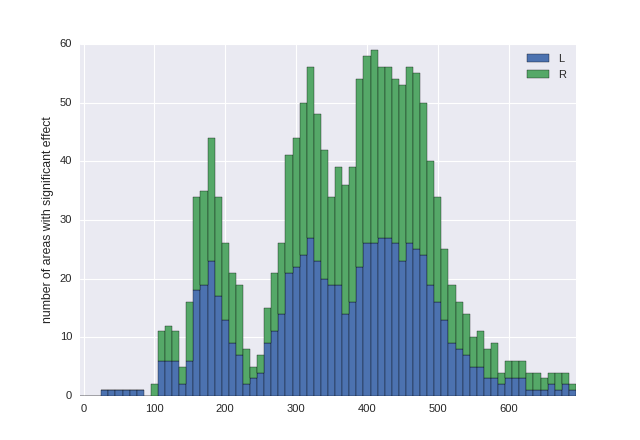

In [7]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Identify areas

In [8]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(ss.get_Glasser_section)
    
    return areas

In [9]:
active_areas(220, 240)

dot_x


area                                        region
only 1    0    L_31pv_ROI-lh                    posterior cingulate cortex
          1    L_LIPd_ROI-lh                      superior parietal cortex
          2    L_ProS_ROI-lh                    posterior cingulate cortex
          3      L_V1_ROI-lh                         primary visual cortex
          4      L_V4_ROI-lh                           early visual cortex
          5   L_d23ab_ROI-lh                    posterior cingulate cortex
          6      R_5L_ROI-rh  paracentral lobular and mid cingulate cortex
          7      R_5m_ROI-rh  paracentral lobular and mid cingulate cortex
          8     R_6ma_ROI-rh  paracentral lobular and mid cingulate cortex
          9     R_AIP_ROI-rh                      superior parietal cortex
          10   R_ProS_ROI-rh                    posterior cingulate cortex
          11     R_V1_ROI-rh                         primary visual cortex
          12     R_V4_ROI-rh                           early visual cortex
          13     R_V8_ROI-rh                  ventral stream visual cortex
          14   R_VMV1_ROI-rh                  ventral stream visual cortex
          15   R_VMV3_ROI-rh                  ventral stream visual cortex
          16  R_d23ab_ROI-rh                    posterior cingulate cortex
intersect 0     L_V3B_ROI-lh                   dorsal stream visual cortex
          1     R_5mv_ROI-rh  paracentral lobular and mid cingulate cortex
only 2    0    L_V3CD_ROI-lh      MT+ complex and neighboring visual areas
          1      L_V6_ROI-lh                   dorsal stream visual cortex
          2     R_11l_ROI-rh              orbital and polar frontal cortex

In [99]:
active_areas(130)

dot_y


area                      region
only 1 0   L_IP0_ROI-lh    inferior parietal cortex
       1  L_POS2_ROI-lh  posterior cingulate cortex
       2   R_DVT_ROI-rh  posterior cingulate cortex
       3   R_IP0_ROI-rh    inferior parietal cortex
       4   R_PGp_ROI-rh    inferior parietal cortex
       5  R_POS1_ROI-rh  posterior cingulate cortex
       6    R_V1_ROI-rh       primary visual cortex
       7    R_V2_ROI-rh         early visual cortex

In [91]:
aa = active_areas(200)
df = pd.concat([aa.area.apply(lambda s: s[0]), aa.area.apply(lambda s: s[2:-7])],
               axis=1, keys=['hemi', 'area'])

lh = df[df.hemi == 'L'].area
rh = df[df.hemi == 'R'].area

print('\nonly L:')
print(', '.join(np.setdiff1d(lh.values, rh.values)))

print('\nonly R:')
print(', '.join(np.setdiff1d(rh.values, lh.values)))

print('\ncommon:')
print(', '.join(np.intersect1d(rh.values, lh.values)))

abs_dot_y

only L:
31pd, 31pv, 7m, d23ab

only R:
PHA1, VVC, v23ab

common:
23d


In [12]:
aa = active_areas(580, 650)
print('\nonly 1:')
print(aa.loc['only 1'])
print('\nintersect:')
print(aa.loc['intersect'])
print('\nonly 2:')
print(aa.loc['only 2'])

response

only 1:
            area                                    region
0   L_MST_ROI-lh  MT+ complex and neighboring visual areas
1  L_V3CD_ROI-lh  MT+ complex and neighboring visual areas

intersect:
              area                                           region
0       L_1_ROI-lh                   somatosensory and motor cortex
1     L_23d_ROI-lh                       posterior cingulate cortex
2    L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
3    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
4       L_2_ROI-lh                   somatosensory and motor cortex
5     L_31a_ROI-lh                       posterior cingulate cortex
6    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
7      L_3a_ROI-lh                   somatosensory and motor cortex
8      L_3b_ROI-lh                   somatosensory and motor cortex
9       L_4_ROI-lh                   somatosensory and motor cortex
10     L_5m_ROI-lh     paracentral lobular an

In [ ]:
active_areas(490, 600)

In [ ]:
active_areas(580, 650)

### Show significant clusters

In [10]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

In [ ]:
print(r_name)

region = 'premotor'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

In [ ]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_VMV1_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


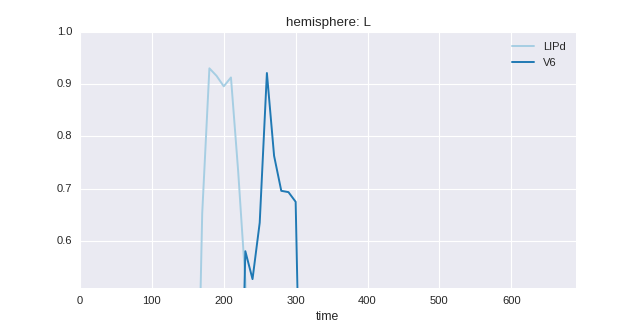

<IPython.core.display.Javascript object>


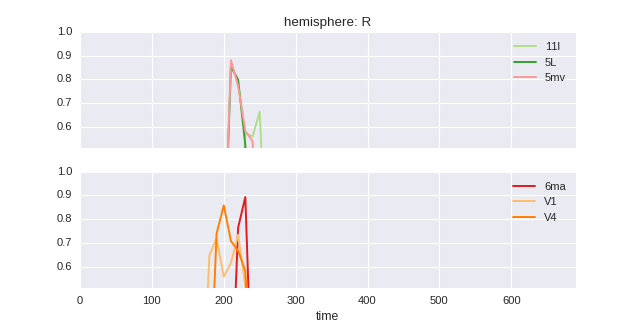

In [15]:
print(r_name)

time = 230

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

## Investigate consistency

In [20]:
src_df.loc[('L_8C_ROI-lh', 450)]

mu_mean         0.024796
mu_std          0.004097
mu_t            6.051603
mu_testval      0.000550
mu_p_large      0.936000
sigma_mean      0.014791
sigma_std       0.003744
theta_mean      0.582226
theta_std       0.092782
lp_mean        67.354911
lp_std          1.756538
overlap        -3.061309
consistency     0.032500
Name: (L_8C_ROI-lh, 450), dtype: float64

In [77]:
for cl in r_clusters.itertuples():
    r_clusters.loc[cl.Index, 'mean_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].mean())
    r_clusters.loc[cl.Index, 'max_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].max())

r_clusters[r_clusters.max_consistency < 0.5].sort_values('start_t')

,label,start_t,end_t,log10p,pval_corrected,region,mean_consistency,max_consistency
cluster,,,,,,,,
1205,L_p24pr_ROI-lh,150,190,-4.984200,1.159024e-04,anterior cingulate and medial prefrontal cortex,0.303400,0.3890
993,L_TPOJ2_ROI-lh,160,190,-4.232302,5.199262e-04,temporo-parieto-occipital junction,0.297750,0.4090
1563,R_7Pm_ROI-rh,160,210,-7.022830,1.580340e-06,superior parietal cortex,0.358083,0.4575
2280,R_V3A_ROI-rh,170,220,-5.224831,7.042977e-05,dorsal stream visual cortex,0.352667,0.4355
189,L_4_ROI-lh,170,210,-4.728347,1.933735e-04,somatosensory and motor cortex,0.330400,0.4725
194,L_52_ROI-lh,180,200,-5.001120,1.117634e-04,insular and frontal opercular cortex,0.162167,0.3810
1508,R_6ma_ROI-rh,210,230,-4.065717,7.238699e-04,paracentral lobular and mid cingulate cortex,0.210833,0.3575
1076,L_V7_ROI-lh,240,290,-6.230374,8.404253e-06,dorsal stream visual cortex,0.413917,0.4635
1814,R_LIPd_ROI-rh,260,290,-5.656487,2.764025e-05,superior parietal cortex,0.335000,0.4195
